# Computational Statistics: Final Project script

In this notebook we implement the two scripts for the Metropolis Algorithm and Auxiliary Gibbs Sampler for the Bayesian Probit.

## Packages import

We start by importing some useful packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics import tsaplots
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.discrete.discrete_model import Probit 
from statsmodels.regression.linear_model import yule_walker

## Metropolis Algorithm

We first implement the Metropolis Hastings algorithm.


We create functions that compute the log-prior, the log-likelihood, the log-posterior, and the Fisher information that we will then use in our algorithm.

In [ ]:
def logprior(beta,beta0,V0):
    "Log-prior supporting either normal priors or a non-informative one" 
    if beta0==None:
        return 0

    return multivariate_normal.logcdf(beta,mean=beta0,cov=V0)

def loglikelihood(X,Y,beta):
    "Log-likelihood of the probit model"
    eta=X@beta

    return np.sum(Y*norm.logcdf(eta)+np.log((1-norm.cdf(eta)))*(1-Y))

def logpost_noconst(X,Y,beta,beta0,V0):
    "Log-posterior of the probit model"
    return logprior(beta,beta0,V0)+loglikelihood(X,Y,beta)

def fisher_info(X,Y,beta):
    "Fisher-information at the current update"
    n=X.shape[0]
    eta=X@beta
    W=np.identity(n)
    H=norm.pdf(eta[:])**2/((norm.cdf(eta[:]))*(1-norm.cdf(eta[:])))
    W=W*H
    return -X.T@W@X

We actually implement the algorithm.

In [ ]:
def metropolis(X,Y,tau,n_burn,n_iterations,beta0=None,V0=None,starting="LS", thinning=0):
    """Implementation of the Metropolis-Hastings algorithm.
    X and Y are the data on which the process is based.
    tau is a paramter scaling the variance of the multivariate normal from which sampling is performed.
    n_burn and n_iterations indicate respecitvely how many burn-in and actual iterations will be performed.
    beta0 and V0 allow for normal prior specifications and are respectively the mean and the variance-covariance matrix.
    starting can be "LS", "ML", or "0" to respictively initiate beta with its Least Square estimate, the Maximum Likelihood one or a vector of 0s
    thinning indicates how many observation need to be skipped before keeping one (e.g. thinning=1 leads to keeping 50% of the observations)
    """
    p = np.shape(X)[1]
    acceptpre=0
    acceptpost=0
    thinningact=thinning

    if starting=="LS":  
        beta=np.linalg.inv(X.T@X)@X.T@Y
    elif starting=="ML":
        beta=Probit(Y,X).fit().params
    elif starting=="0":
        beta=np.zeros(p)
    else:
        raise Exception("""starting can be "LS","ML", or "0" """)

    Betapre=np.zeros((n_burn,p))

    for i in range(n_burn):
        V=np.linalg.inv(fisher_info(X,Y,beta))
        beta_prop=np.random.multivariate_normal(beta,tau*V)
        ratio=logpost_noconst(X,Y,beta_prop,beta0,V0)-logpost_noconst(X,Y,beta,beta0,V0)
        if np.random.uniform(size=1)<np.exp(ratio):
            acceptpre+=1
            beta=beta_prop
        if thinningact==0:
            Betapre[i,:]=beta
            thinningact=thinning
        else:
            thinningact-=1


    Betapost=np.zeros((n_iterations,p))

    for i in range(n_iterations):
        V=np.linalg.inv(fisher_info(X,Y,beta))
        beta_prop=np.random.multivariate_normal(beta,tau*V)
        ratio=logpost_noconst(X,Y,beta_prop,beta0,V0)-logpost_noconst(X,Y,beta,beta0,V0)
        if np.random.uniform(size=1)<np.exp(ratio):
            acceptpost+=1
            beta=beta_prop
        if thinningact==0:
            Betapost[i,:]=beta
            thinningact=thinning
        else:
            thinningact-=1
        
    return np.concatenate([Betapre[Betapre[:,0]!=0,:],Betapost[Betapost[:,0]!=0]]), Betapre[Betapre[:,0]!=0], Betapost[Betapost[:,0]!=0], (acceptpre+acceptpost)/(n_burn+n_iterations),acceptpre/n_burn, acceptpost/n_iterations


## Auxiliary Variable Gibbs Sampler

We now implement the Auxiliary Variable Gibbs Sampler.

We start by creating the full conditionals for Z and Beta that we will then use in our algorithm.

In [ ]:
def full_conditional_Z(X,Y,beta):
    "Full conditional of Z"
    eta=X@beta
    Z=np.zeros(len(Y))
    a=np.zeros(len(Y))
    b=np.zeros(len(Y))

    a[Y==0]=-np.inf
    b[Y==1]=np.inf
    
    U=np.random.uniform(size=len(Y))
    p=norm.cdf(a-eta[:])+U*(norm.cdf(b-eta[:])-norm.cdf(a-eta[:]))
    Z=eta+norm.ppf(p)
    return Z

def full_conditional_beta(X,Y,Z,beta0,V0):
    "Full conditional of Beta"
    Beta=np.zeros(X.shape[1])
    if beta0==None and V0==None:    
       mean=np.linalg.inv(X.T@X)@X.T@Z
       cov=np.linalg.inv(X.T@X)
    else:
        V0_inv=np.linalg.inv(V0)
        mean=np.linalg.inv(V0_inv+X.T@X)@(V0_inv@beta0+X.T@Z)
        cov=np.linalg.inv(V0_inv+X.T@X)
    Beta=np.random.multivariate_normal(mean,cov)
    return Beta

We implement the algorithm.

In [ ]:
def auxiliary_gibbs_sampler(X,Y,n_burn,n_iterations,beta0=None,V0=None,starting="LS", thinning=0):
    """Implementation of the Auxiliary Variables Gibbs Sampler.
    X and Y are the data on which the process is based.
    n_burn and n_iterations indicate respecitvely how many burn-in and actual iterations will be performed.
    beta0 and V0 allow for normal prior specifications and are respectively the mean and the variance-covariance matrix.
    starting can be "LS", "ML", or "0" to respictively initiate beta with its Least Square estimate, the Maximum Likelihood one or a vector of 0s
    thinning indicates how many observation need to be skipped before keeping one (e.g. thinning=1 leads to keeping 50% of the observations)
    Note that the algorithm is implemented with immediate updating to improve performance.
    """
    p = X.shape[1]
    thinningact=thinning


    if starting=="LS":  
        beta=np.linalg.inv(X.T@X)@X.T@Y
    elif starting=="ML":
        beta=Probit(Y,X).fit().params
    elif starting=="0":
        beta=np.zeros(p)
    else:
        raise Exception("""starting can be "LS","ML", or "0" """)
    Betapre=np.zeros(shape=(n_burn,p))
    
    for i in range(n_burn):
        Z=full_conditional_Z(X,Y,beta)
        beta=full_conditional_beta(X,Y,Z,beta0,V0)
        if thinningact==0:
            Betapre[i,:]=beta
            thinningact=thinning
        else:
            thinningact-=1

    Betapost=np.zeros(shape=(n_iterations,p))
    for i in range(n_iterations):
        Z=full_conditional_Z(X,Y,beta)
        beta=full_conditional_beta(X,Y,Z,beta0,V0)
        if thinningact==0:
            Betapost[i,:]=beta
            thinningact=thinning
        else:
            thinningact-=1
            
    return np.concatenate([Betapre[Betapre[:,0]!=0,:],Betapost[Betapost[:,0]!=0]]), Betapre[Betapre[:,0]!=0], Betapost[Betapost[:,0]!=0]

# Diagnostics Functions

We create some diagnostics that will be useful in analyzing the results.

We implement the Gelman Rubin statistics.

In [ ]:
def gelman_rubin(betas):
    """
    Computes the Gelman Rubin statistics for a set of parameters.
    betas here should be a list of beta chains.
    """
    n_chains=len(betas)
    n_iterations=len(betas[0][:,0])
    n_beta=len(betas[0][0,:])
    beta_means=np.zeros((n_chains,n_beta))

    for i in range(n_chains):
        beta_means[i,:]=np.mean(betas[i],axis=0)

    beta_mean=np.mean(beta_means,axis=0)
    B=n_iterations/(n_chains-1)*np.sum((beta_means-beta_mean)**2,axis=0)
    diff=np.zeros((n_chains,n_iterations,n_beta))

    for i in range(n_chains):
        diff[i]=(betas[i]-beta_means[i])**2

    W=(1/(n_chains*(n_iterations-1)))*np.sum(np.sum(diff,axis=0),axis=0)
    var_post=((n_iterations-1)/n_iterations)*W+(1/n_iterations)*B
    R=var_post/W
    return R

We create some functions that help us in plotting and showcasing the results

In [ ]:
def graphs(betapost,betapost_1,betapost_2, beta=0):
  
  fig, ax = plt.subplots(2, 3, figsize=(11,10))

  ax[0,0].plot(betapost[:,beta])
  ax[0,0].set_title("Least Square")
  ax[0,1].plot(betapost_1[:,beta])
  ax[0,1].set_title("Maximum Likelihood")
  ax[0,2].plot(betapost_2[:,beta])
  ax[0,2].set_title("Vector of 0s")
  ax[1,0].hist(betapost[:,beta], bins=25)
  ax[1,1].hist(betapost_1[:,beta], bins=25)
  ax[1,2].hist(betapost_2[:,beta], bins=25)
  fig.suptitle(f'Beta {beta} traceplots and histograms at different starting points')

  fig, ax = plt.subplots(1, 3, figsize=(20,5))

  fig.suptitle(f'Beta {beta} autocorrelation at different starting points')
  tsaplots.plot_acf(betapost[:,beta],ax=ax[0], title="Least Square")
  tsaplots.plot_acf(betapost_1[:,beta],ax=ax[1], title="Maximum Likelihood")
  tsaplots.plot_acf(betapost_2[:,beta],ax=ax[2], title="Vector of 0s")

  plt.show()


def stats(beta,betapost, beta_1,betapost_1, beta_2,betapost_2,
accept=None, acceptpre=None, acceptpost=None,accept_1=None, acceptpre_1=None, acceptpost_1=None,accept_2=None, acceptpre_2=None, acceptpost_2=None):
  print(f'''\n Beta estimate having as starting point: \n Least Square: {np.mean(betapost, axis = 0)} \n
   Maximum Likelihood: {np.mean(betapost_1, axis = 0)} \n
   Vector of 0s: {np.mean(betapost_2, axis = 0)} \n''')
  print("Mean of beta estimates: ",(np.mean(betapost, axis = 0) + np.mean(betapost_1, axis = 0) + np.mean(betapost_2, axis = 0))/3)
  
  if not accept is None:
    print(f'''Overall acceptance rate having as starting point: \n
    Least Square: {accept},  Maximum Likelihood: {accept_1}, Vector of 0s: {accept_2} \n ''')
    print(f'''Burn-in acceptance rate having as starting point: \n
    Least Square: {acceptpre},  Maximum Likelihood: {acceptpre_1}, Vector of 0s: {acceptpre_2} \n''')
    print(f'''Iterations acceptance rate having as starting point: \n
    Least Square: {acceptpost},  Maximum Likelihood: {acceptpost_1}, Vector of 0s: {acceptpost_2} \n''')

  print("Gelman Rubin statistics: ", gelman_rubin([betapost,betapost_1,betapost_2]))

# Results

We now look at how the algorithms perform

## Simulated Data

We now look at how the two algorithms perform on simulated data.




We generate some sample data we will use to test the performances of the two algorithms.

In [ ]:
n=1000
p=2
np.random.seed(234)
X=np.random.normal(size=(n,p))
X = np.hstack((np.ones((n,1)), X))
beta=[1,-1,1.5]
eta=X@beta

pi=norm.cdf(eta)
Y=np.random.binomial(1,pi)

### Simulated data, Metropolis algorithm with uninformative prior

Optimization terminated successfully.
         Current function value: 0.283036
         Iterations 7

 Beta estimate having as starting point: 
 Least Square: [ 1.06976663 -0.97215496  1.59640611] 

   Maximum Likelihood: [ 1.06371692 -0.9825711   1.59576545] 

   Vector of 0s: [ 1.06792933 -0.96592948  1.60485561] 

Mean of beta estimates:  [ 1.06713763 -0.97355184  1.59900906]
Overall acceptance rate having as starting point: 

    Least Square: 0.392,  Maximum Likelihood: 0.393, Vector of 0s: 0.3825 
 
Burn-in acceptance rate having as starting point: 

    Least Square: 0.414,  Maximum Likelihood: 0.405, Vector of 0s: 0.389 

Iterations acceptance rate having as starting point: 

    Least Square: 0.37,  Maximum Likelihood: 0.381, Vector of 0s: 0.376 

Gelman Rubin statistics:  [1.00096561 1.01301995 1.00323638]


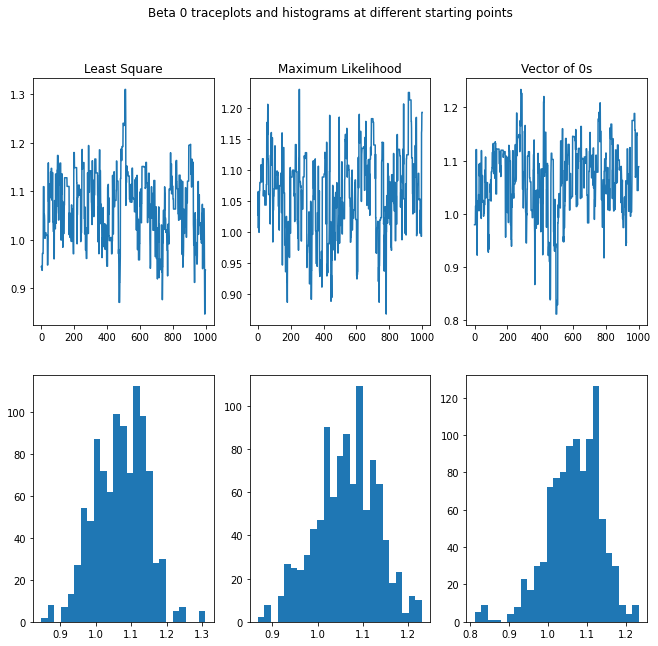

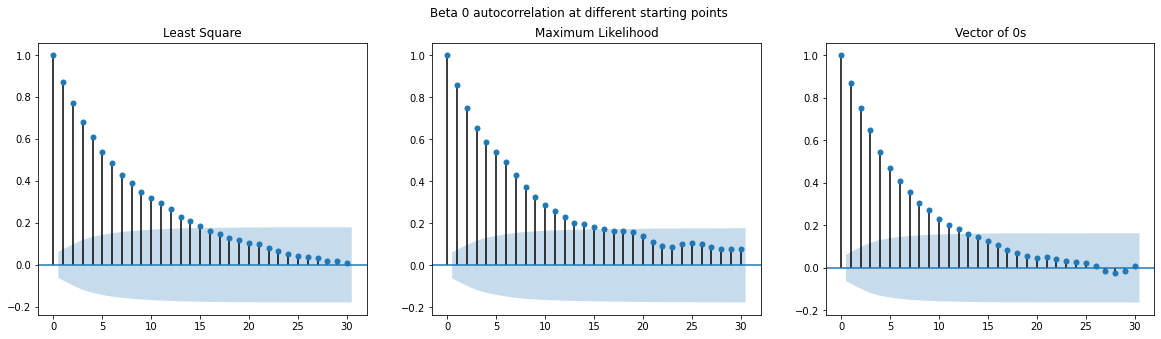

In [ ]:
beta,betapre,betapost,accept, acceptpre, acceptpost=metropolis(X,Y,1,1000,1000)
beta_1,betapre_1,betapost_1,accept_1, acceptpre_1, acceptpost_1=metropolis(X,Y,1,1000,1000, starting="ML")
beta_2,betapre_2,betapost_2,accept_2, acceptpre_2, acceptpost_2=metropolis(X,Y,1,1000,1000, starting="0")

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2,accept, acceptpre, acceptpost,accept_1, acceptpre_1, acceptpost_1, accept_2, acceptpre_2, acceptpost_2)

graphs(betapost,betapost_1,betapost_2, beta=0)

The autocorrelation tends to be too persistent. We introduce thinning to ensure it goes down quicker.

Optimization terminated successfully.
         Current function value: 0.283036
         Iterations 7

 Beta estimate having as starting point: 
 Least Square: [ 1.06869221 -0.96897909  1.58309628] 

   Maximum Likelihood: [ 1.07201566 -0.97708487  1.60063594] 

   Vector of 0s: [ 1.06840626 -0.96668586  1.59896558] 

Mean of beta estimates:  [ 1.06970471 -0.97091661  1.5942326 ]
Overall acceptance rate having as starting point: 

    Least Square: 0.4016363636363636,  Maximum Likelihood: 0.39745454545454545, Vector of 0s: 0.3916363636363636 
 
Burn-in acceptance rate having as starting point: 

    Least Square: 0.408,  Maximum Likelihood: 0.40675, Vector of 0s: 0.393 

Iterations acceptance rate having as starting point: 

    Least Square: 0.38466666666666666,  Maximum Likelihood: 0.37266666666666665, Vector of 0s: 0.388 

Gelman Rubin statistics:  [0.99952317 1.004848   1.01444206]


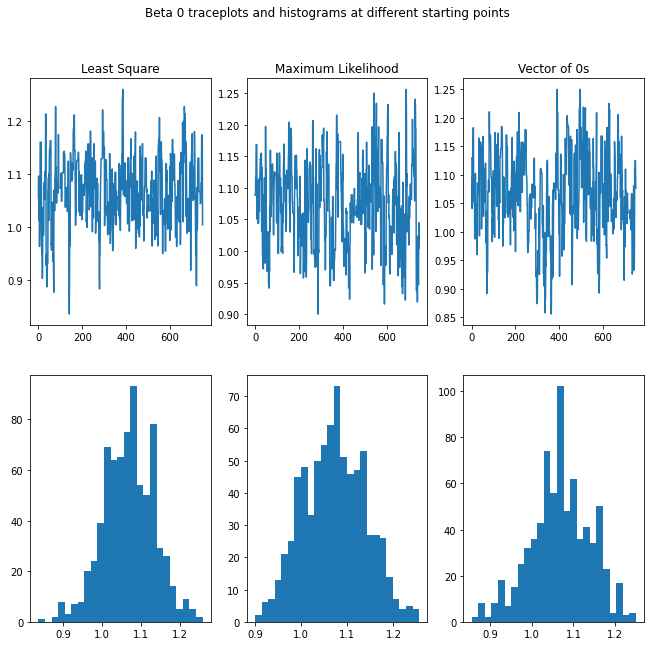

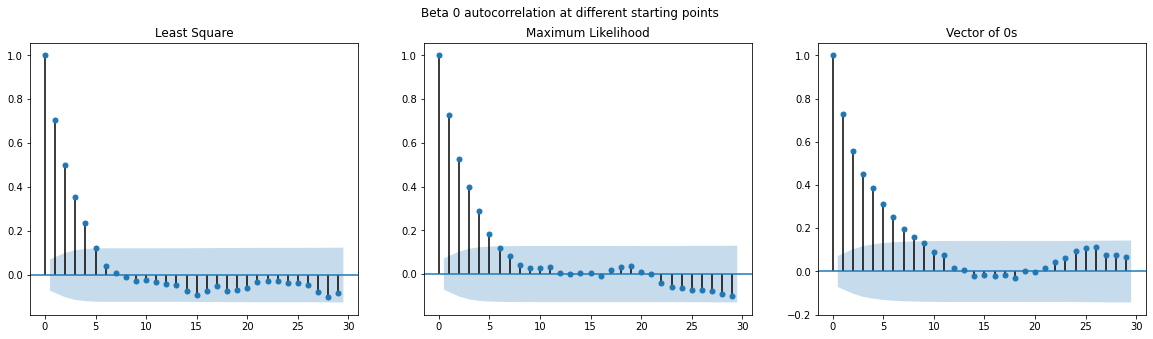

In [ ]:
beta,betapre,betapost,accept, acceptpre, acceptpost=metropolis(X,Y,1,4000,1500,thinning=1)
beta_1,betapre_1,betapost_1,accept_1, acceptpre_1, acceptpost_1=metropolis(X,Y,1,4000,1500, starting="ML", thinning=1)
beta_2,betapre_2,betapost_2,accept_2, acceptpre_2, acceptpost_2=metropolis(X,Y,1,4000,1500, starting="0", thinning=1)

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2,accept, acceptpre, acceptpost,accept_1, acceptpre_1, acceptpost_1, accept_2, acceptpre_2, acceptpost_2)

graphs(betapost,betapost_1,betapost_2, beta=0)

### Simulated data, Auxiliary Gibbs Sampler algorithm with uninformative prior

Optimization terminated successfully.
         Current function value: 0.283036
         Iterations 7

 Beta estimate having as starting point: 
 Least Square: [ 1.08297479 -0.97640344  1.62184832] 

   Maximum Likelihood: [ 1.11260248 -1.01048632  1.66146736] 

   Vector of 0s: [ 1.09389418 -0.98774812  1.63164455] 

Mean of beta estimates:  [ 1.09649048 -0.99154596  1.63832008]
Gelman Rubin statistics:  [1.04119275 1.05138287 1.04966805]


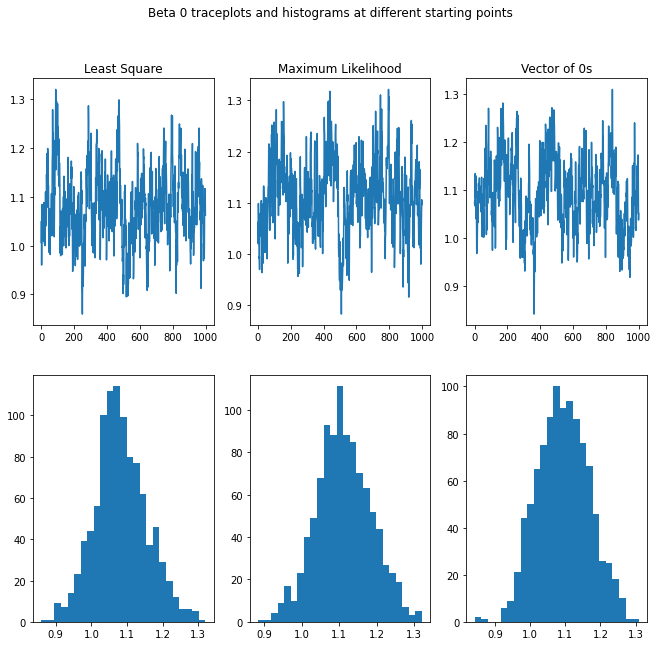

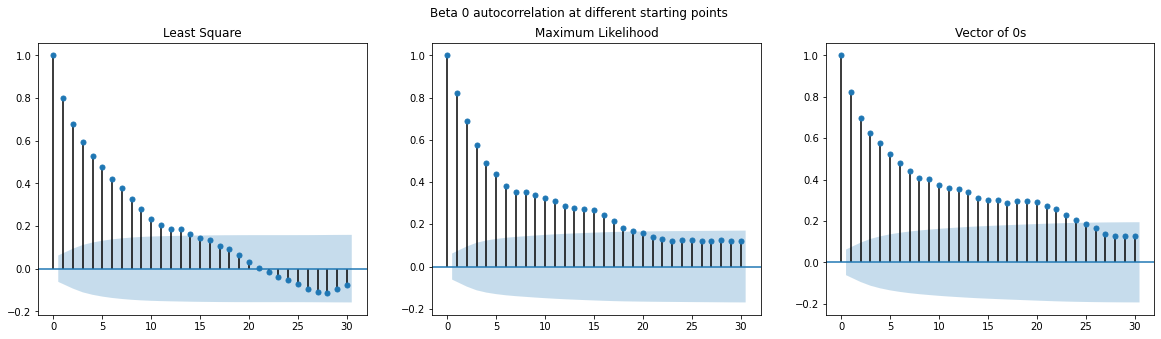

In [ ]:
beta,betapre,betapost=auxiliary_gibbs_sampler(X,Y,1000,1000)
beta_1,betapre_1,betapost_1=auxiliary_gibbs_sampler(X,Y,1000,1000, starting="ML")
beta_2,betapre_2,betapost_2=auxiliary_gibbs_sampler(X,Y,500,1000, starting="0")

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2)

graphs(betapost,betapost_1,betapost_2, beta=0)

We see that the autocorrelations are even more persistent than before. We, thus, introduce thinning.

Optimization terminated successfully.
         Current function value: 0.283036
         Iterations 7

 Beta estimate having as starting point: 
 Least Square: [ 1.09991237 -0.99623026  1.64463359] 

   Maximum Likelihood: [ 1.10292408 -0.99656473  1.64285786] 

   Vector of 0s: [ 1.11593577 -1.01205861  1.66800017] 

Mean of beta estimates:  [ 1.10625741 -1.00161787  1.65183054]
Gelman Rubin statistics:  [1.00980915 1.01248995 1.01623001]


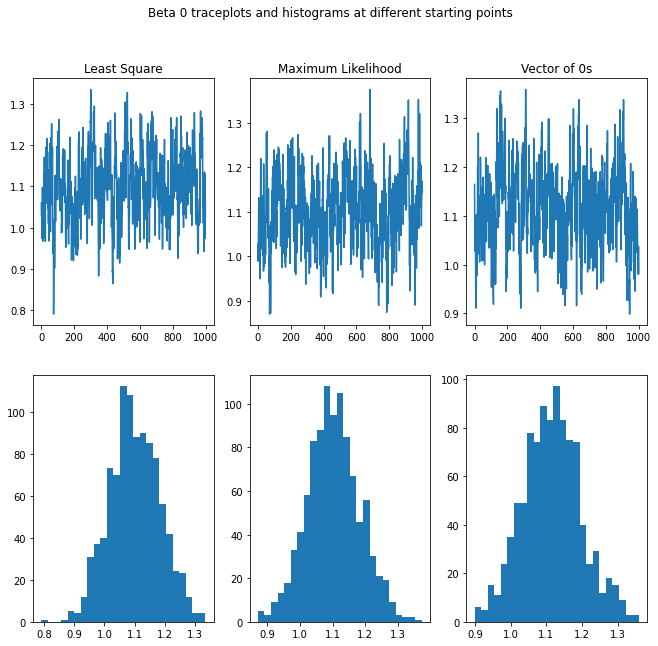

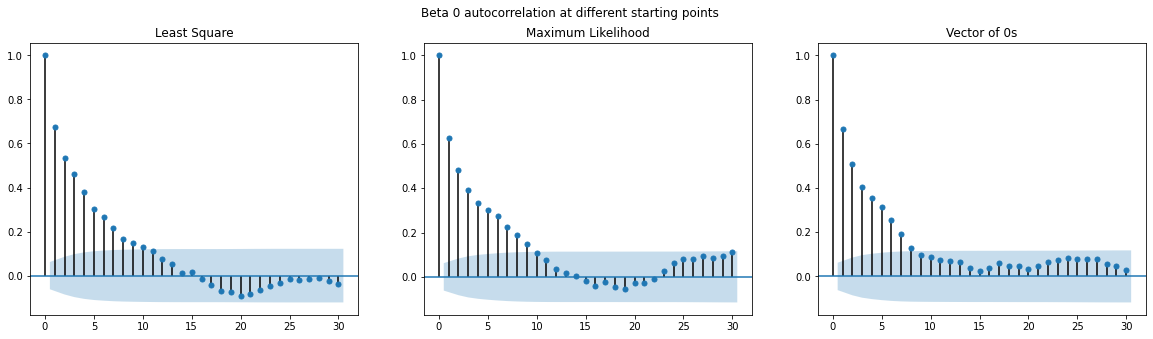

In [ ]:
beta,betapre,betapost=auxiliary_gibbs_sampler(X,Y,3000,3000,thinning=2)
beta_1,betapre_1,betapost_1=auxiliary_gibbs_sampler(X,Y,3000,3000, starting="ML", thinning=2)
beta_2,betapre_2,betapost_2=auxiliary_gibbs_sampler(X,Y,3000,3000, starting="0", thinning=2)

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2)

graphs(betapost,betapost_1,betapost_2, beta=0)

The results are now satisfactory.

### Simulated data, Metropolis algorithm with weak normal prior

We now introduce a vague normal prior.

Optimization terminated successfully.
         Current function value: 0.283036
         Iterations 7

 Beta estimate having as starting point: 
 Least Square: [ 1.06749841 -0.95984333  1.58743001] 

   Maximum Likelihood: [ 1.07713595 -0.975931    1.58926464] 

   Vector of 0s: [ 1.06462053 -0.95570553  1.58834947] 

Mean of beta estimates:  [ 1.06975163 -0.96382662  1.58834804]
Overall acceptance rate having as starting point: 

    Least Square: 0.3955,  Maximum Likelihood: 0.3905, Vector of 0s: 0.3975 
 
Burn-in acceptance rate having as starting point: 

    Least Square: 0.4,  Maximum Likelihood: 0.375, Vector of 0s: 0.422 

Iterations acceptance rate having as starting point: 

    Least Square: 0.391,  Maximum Likelihood: 0.406, Vector of 0s: 0.373 

Gelman Rubin statistics:  [1.00918212 1.0225033  0.99914672]


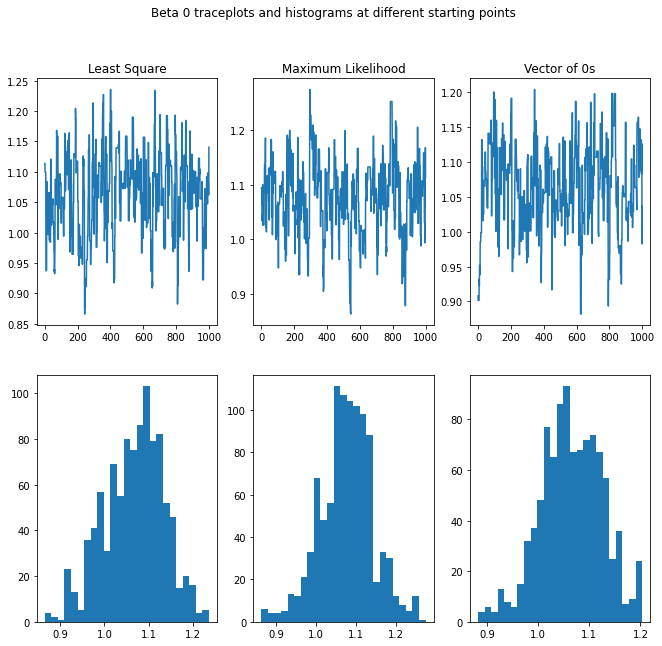

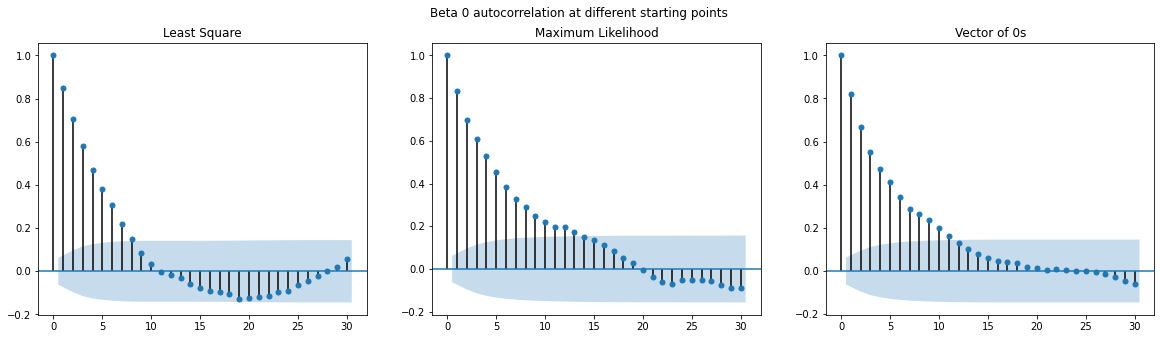

In [ ]:
beta0=[0,0,0]
V0=np.identity(3)

beta,betapre,betapost,accept, acceptpre, acceptpost=metropolis(X,Y,1,1000,1000,beta0,V0)
beta_1,betapre_1,betapost_1,accept_1, acceptpre_1, acceptpost_1=metropolis(X,Y,1,1000,1000,beta0,V0, starting="ML")
beta_2,betapre_2,betapost_2,accept_2, acceptpre_2, acceptpost_2=metropolis(X,Y,1,1000,1000,beta0,V0, starting="0")

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2,accept, acceptpre, acceptpost,accept_1, acceptpre_1, acceptpost_1, accept_2, acceptpre_2, acceptpost_2)

graphs(betapost,betapost_1,betapost_2, beta=0)

The results are satisfactory.

### Simulated data, Auxiliary Gibbs Sampler algorithm with weak normal prior

Note we again have thinning as we have the same persistent autocorrelation as in the previous case.

Optimization terminated successfully.
         Current function value: 0.283036
         Iterations 7

 Beta estimate having as starting point: 
 Least Square: [ 1.08345335 -0.97810511  1.61632878] 

   Maximum Likelihood: [ 1.07994627 -0.97682921  1.61796018] 

   Vector of 0s: [ 1.07759088 -0.97099876  1.60327715] 

Mean of beta estimates:  [ 1.08033017 -0.97531103  1.61252204]
Gelman Rubin statistics:  [1.00045192 1.00148962 1.00531029]


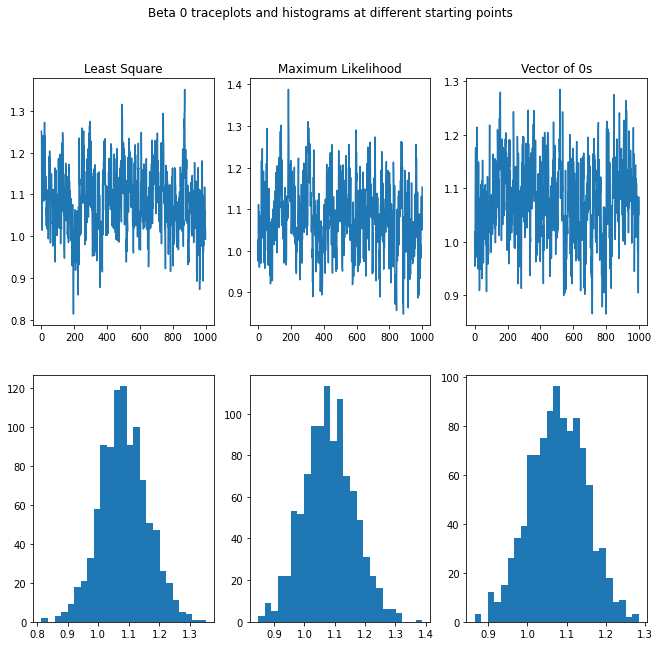

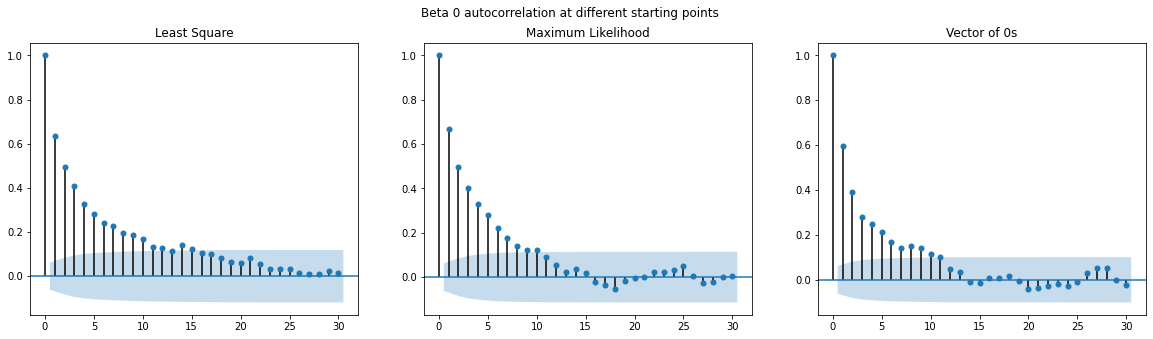

In [ ]:
beta,betapre,betapost=auxiliary_gibbs_sampler(X,Y,3000,3000, beta0,V0, thinning=2)
beta_1,betapre_1,betapost_1=auxiliary_gibbs_sampler(X,Y,3000,3000, beta0,V0,starting="ML", thinning=2)
beta_2,betapre_2,betapost_2=auxiliary_gibbs_sampler(X,Y,3000,3000,beta0,V0,starting="0", thinning=2)

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2)

graphs(betapost,betapost_1,betapost_2, beta=0)

The results are now satisfactory.

### Simulated data, Metropolis algorithm with strong normal prior

We now introduce a stronger normal prior (the means of the betas are close to the true ones and the variance is way lower).

Optimization terminated successfully.
         Current function value: 0.283036
         Iterations 7

 Beta estimate having as starting point: 
 Least Square: [ 1.08223835 -0.99343061  1.61563441] 

   Maximum Likelihood: [ 1.06764252 -0.97570348  1.59237003] 

   Vector of 0s: [ 1.07075983 -0.95430856  1.59767349] 

Mean of beta estimates:  [ 1.0735469  -0.97448088  1.60189264]
Overall acceptance rate having as starting point: 

    Least Square: 0.3725,  Maximum Likelihood: 0.3935, Vector of 0s: 0.38 
 
Burn-in acceptance rate having as starting point: 

    Least Square: 0.406,  Maximum Likelihood: 0.382, Vector of 0s: 0.382 

Iterations acceptance rate having as starting point: 

    Least Square: 0.339,  Maximum Likelihood: 0.405, Vector of 0s: 0.378 

Gelman Rubin statistics:  [1.01254608 1.08113756 1.02638829]


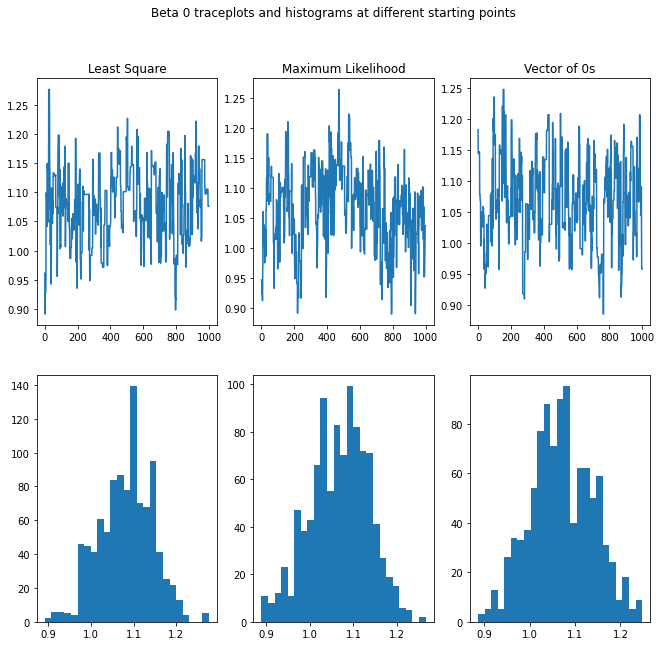

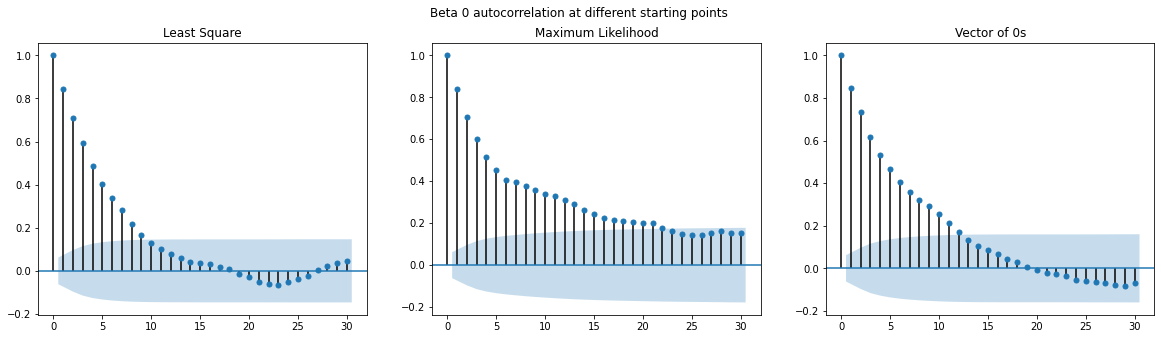

In [ ]:
beta0=[0.9,-1.1,1.7]
V0=np.identity(3)*0.2

beta,betapre,betapost,accept, acceptpre, acceptpost=metropolis(X,Y,1,1000,1000,beta0,V0)
beta_1,betapre_1,betapost_1,accept_1, acceptpre_1, acceptpost_1=metropolis(X,Y,1,1000,1000,beta0,V0, starting="ML")
beta_2,betapre_2,betapost_2,accept_2, acceptpre_2, acceptpost_2=metropolis(X,Y,1,1000,1000,beta0,V0, starting="0")

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2,accept, acceptpre, acceptpost,accept_1, acceptpre_1, acceptpost_1, accept_2, acceptpre_2, acceptpost_2)

graphs(betapost,betapost_1,betapost_2, beta=0)

The results are satisfactory.

### Simulated data, Auxiliary Gibbs Sampler algorithm with strong normal prior

Note we again have thinning as we have the same persistent autocorrelation as in the previous two cases.

Optimization terminated successfully.
         Current function value: 0.283036
         Iterations 7

 Beta estimate having as starting point: 
 Least Square: [ 1.1001452  -1.00148466  1.64684335] 

   Maximum Likelihood: [ 1.09931464 -0.99860834  1.64959179] 

   Vector of 0s: [ 1.10301176 -0.99505276  1.64905802] 

Mean of beta estimates:  [ 1.10082387 -0.99838192  1.64849772]
Gelman Rubin statistics:  [0.99964525 1.000808   0.99920775]


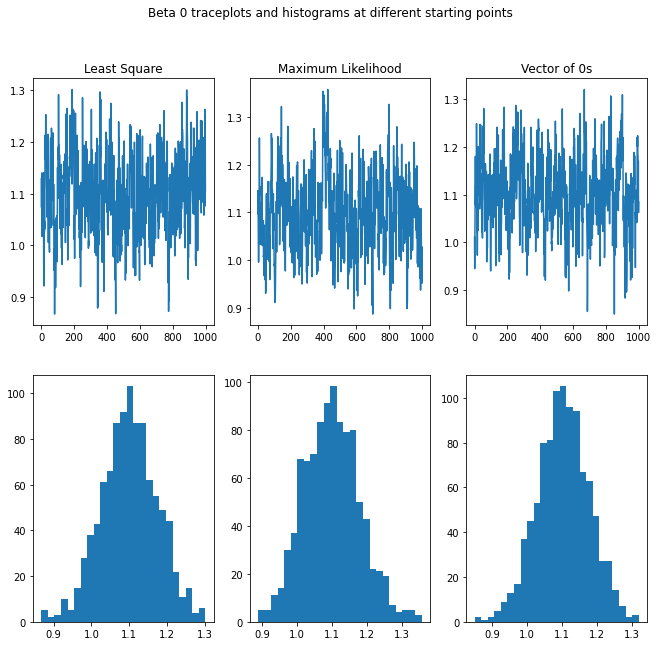

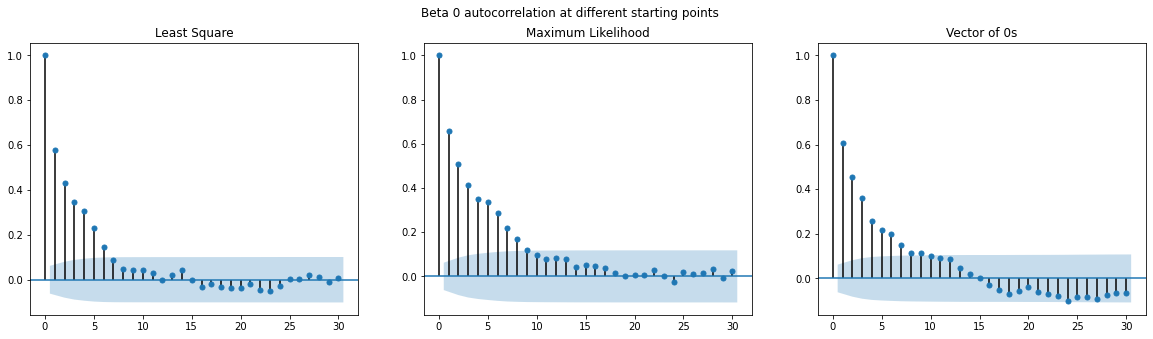

In [ ]:
beta,betapre,betapost=auxiliary_gibbs_sampler(X,Y,3000,3000, beta0,V0, thinning=2)
beta_1,betapre_1,betapost_1=auxiliary_gibbs_sampler(X,Y,3000,3000, beta0,V0,starting="ML", thinning=2)
beta_2,betapre_2,betapost_2=auxiliary_gibbs_sampler(X,Y,3000,3000,beta0,V0,starting="0", thinning=2)

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2)

graphs(betapost,betapost_1,betapost_2, beta=0)

The results are satisfactory.

## Real Data

In [ ]:
#https://www.kaggle.com/uciml/pima-indians-diabetes-database
data = pd.read_csv("/content/diabetes.csv")

In [ ]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
Y = data["Outcome"].to_numpy()
X = data[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X=sm.add_constant(X)

In [ ]:
model=Probit(Y,X)
model_fit=model.fit()
print(model_fit.summary())

Optimization terminated successfully.
         Current function value: 0.472380
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                  768
Model:                         Probit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Fri, 07 Jan 2022   Pseudo R-squ.:                  0.2697
Time:                        13:28:34   Log-Likelihood:                -362.79
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 2.736e-53
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5156      0.055     -9.366      0.000      -0.624      -0.408
x1             0.2434      0.

### Real data, Metropolis algorithm with uninformative prior

Optimization terminated successfully.
         Current function value: 0.472380
         Iterations 6

 Beta estimate having as starting point: 
 Least Square: [-0.52452444  0.24002963  0.62907553 -0.16175667  0.02121168 -0.07958469
  0.40307867  0.16013725  0.13103144] 

   Maximum Likelihood: [-0.50926258  0.25450227  0.63373232 -0.15676866  0.03746944 -0.09595275
  0.40700475  0.17144082  0.12248904] 

   Vector of 0s: [-0.51690322  0.24380535  0.62886108 -0.16779501  0.05563874 -0.09266468
  0.39393058  0.16503523  0.14602587] 

Mean of beta estimates:  [-0.51689675  0.24611242  0.63055631 -0.16210678  0.03810662 -0.08940071
  0.401338    0.16553777  0.13318212]
Overall acceptance rate having as starting point: 

    Least Square: 0.155,  Maximum Likelihood: 0.1665, Vector of 0s: 0.1685 
 
Burn-in acceptance rate having as starting point: 

    Least Square: 0.162,  Maximum Likelihood: 0.179, Vector of 0s: 0.184 

Iterations acceptance rate having as starting point: 

    Least Squ

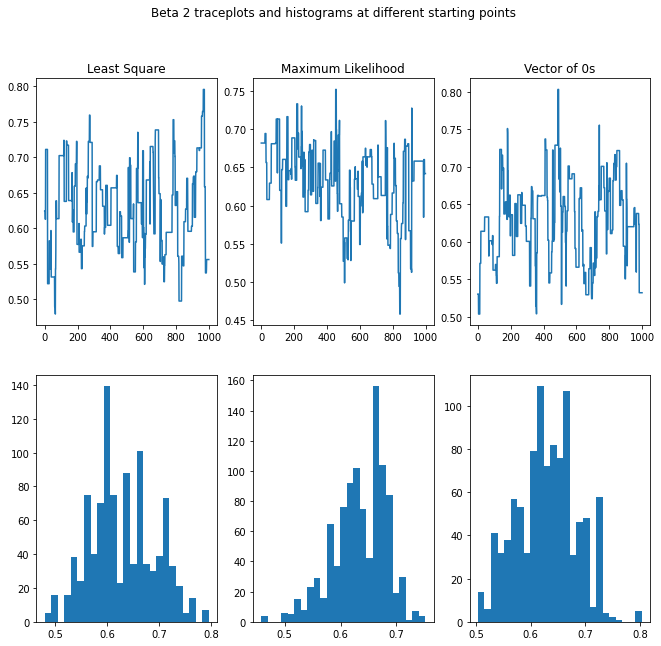

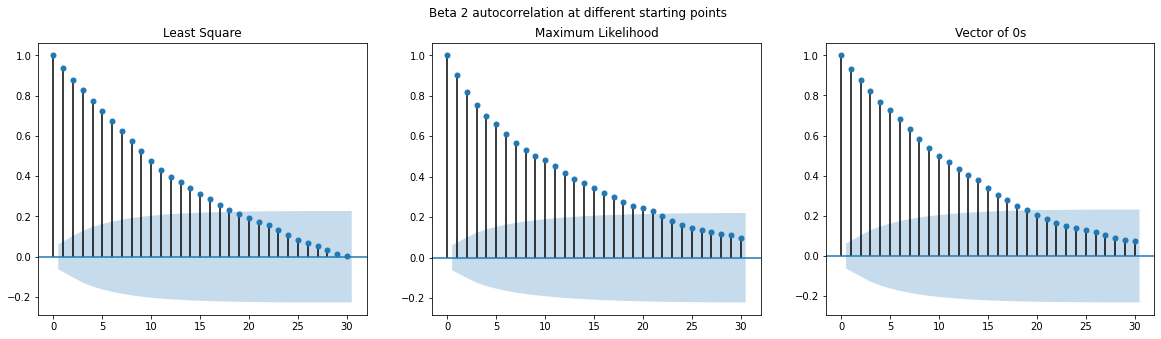

In [ ]:
beta,betapre,betapost,accept, acceptpre, acceptpost=metropolis(X,Y,1,1000,1000)
beta_1,betapre_1,betapost_1,accept_1, acceptpre_1, acceptpost_1=metropolis(X,Y,1,1000,1000, starting="ML")
beta_2,betapre_2,betapost_2,accept_2, acceptpre_2, acceptpost_2=metropolis(X,Y,1,1000,1000, starting="0")

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2,accept, acceptpre, acceptpost,accept_1, acceptpre_1, acceptpost_1, accept_2, acceptpre_2, acceptpost_2)

graphs(betapost,betapost_1,betapost_2, beta=2)

This has various issues

First, the acceptance rate we get with this is too low (this means the variability in the proposals is too high). We proceed to reduce tau so that the algorithm reaches an acceptance of around 40%

Optimization terminated successfully.
         Current function value: 0.472380
         Iterations 6

 Beta estimate having as starting point: 
 Least Square: [-0.51759693  0.23686541  0.63372425 -0.15337891  0.02228591 -0.08983359
  0.40801935  0.15790703  0.09930294] 

   Maximum Likelihood: [-0.52571045  0.24070349  0.62344801 -0.13295981  0.02969081 -0.09061599
  0.39144065  0.15880695  0.13140953] 

   Vector of 0s: [-0.5081184   0.2385509   0.63867142 -0.14608976  0.0275139  -0.09640309
  0.39947719  0.16429156  0.11772298] 

Mean of beta estimates:  [-0.51714193  0.2387066   0.6319479  -0.14414283  0.02649687 -0.09228422
  0.39964573  0.16033518  0.11614515]
Overall acceptance rate having as starting point: 

    Least Square: 0.385,  Maximum Likelihood: 0.3945, Vector of 0s: 0.396 
 
Burn-in acceptance rate having as starting point: 

    Least Square: 0.373,  Maximum Likelihood: 0.391, Vector of 0s: 0.416 

Iterations acceptance rate having as starting point: 

    Least Squa

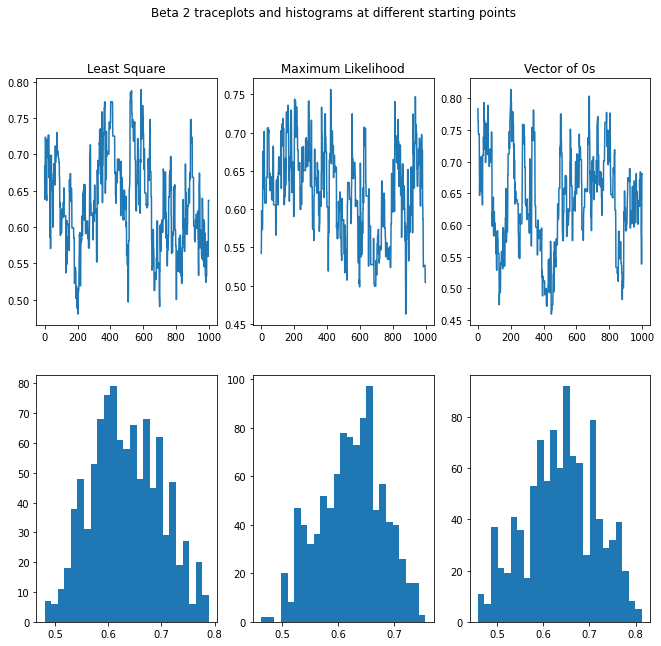

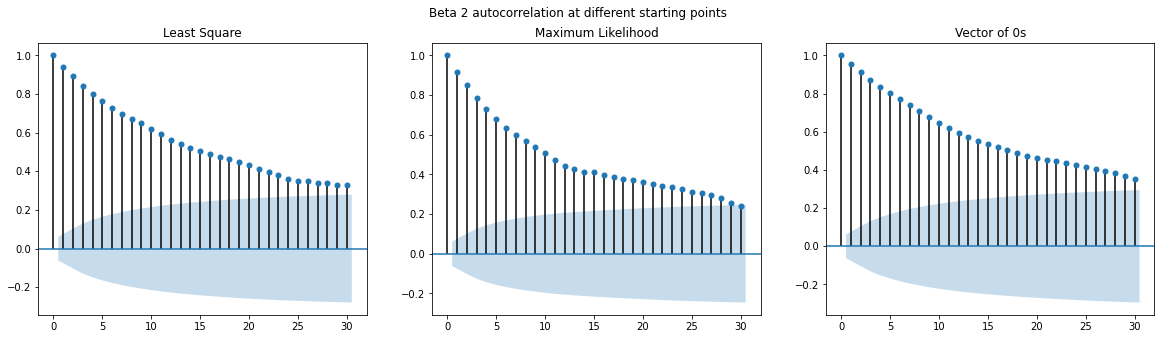

In [ ]:
beta,betapre,betapost,accept, acceptpre, acceptpost=metropolis(X,Y,0.35,1000,1000)
beta_1,betapre_1,betapost_1,accept_1, acceptpre_1, acceptpost_1=metropolis(X,Y,0.35,1000,1000, starting="ML")
beta_2,betapre_2,betapost_2,accept_2, acceptpre_2, acceptpost_2=metropolis(X,Y,0.35,1000,1000, starting="0")

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2,accept, acceptpre, acceptpost,accept_1, acceptpre_1, acceptpost_1, accept_2, acceptpre_2, acceptpost_2)

graphs(betapost,betapost_1,betapost_2, beta=2)

The variability in the trace plot is high. This might indicate the chain requires more iterations to fully explore the posterior. We, thus, try to increase them.

Optimization terminated successfully.
         Current function value: 0.472380
         Iterations 6

 Beta estimate having as starting point: 
 Least Square: [-0.52140575  0.2602947   0.63661205 -0.15049699  0.00839653 -0.08279546
  0.42087643  0.16795379  0.11064531] 

   Maximum Likelihood: [-0.50810297  0.22096036  0.63537835 -0.12747087  0.00604865 -0.08809753
  0.4068761   0.17265958  0.11968622] 

   Vector of 0s: [-0.48721486  0.23757106  0.64088673 -0.13800712  0.0109879  -0.09564435
  0.40925505  0.17159708  0.10398471] 

Mean of beta estimates:  [-0.50557453  0.23960871  0.63762571 -0.13865833  0.00847769 -0.08884578
  0.41233586  0.17073682  0.11143874]
Overall acceptance rate having as starting point: 

    Least Square: 0.3936,  Maximum Likelihood: 0.3968, Vector of 0s: 0.408 
 
Burn-in acceptance rate having as starting point: 

    Least Square: 0.3893333333333333,  Maximum Likelihood: 0.4026666666666667, Vector of 0s: 0.43 

Iterations acceptance rate having as starti

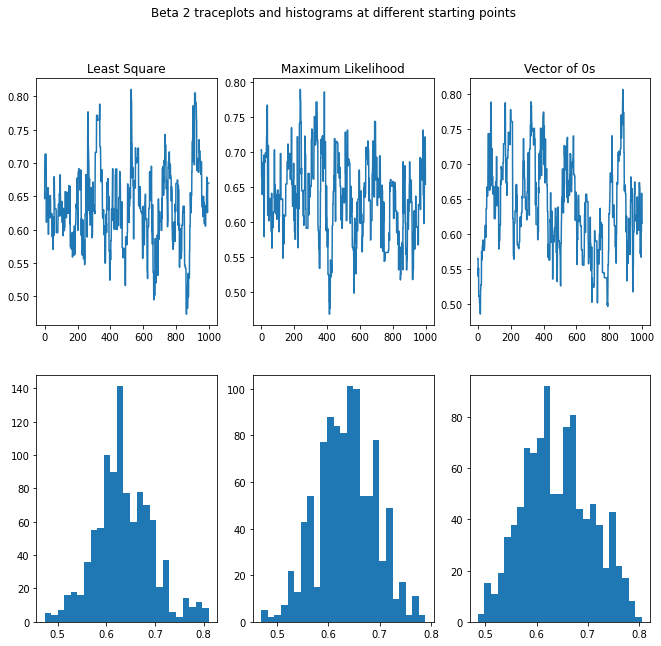

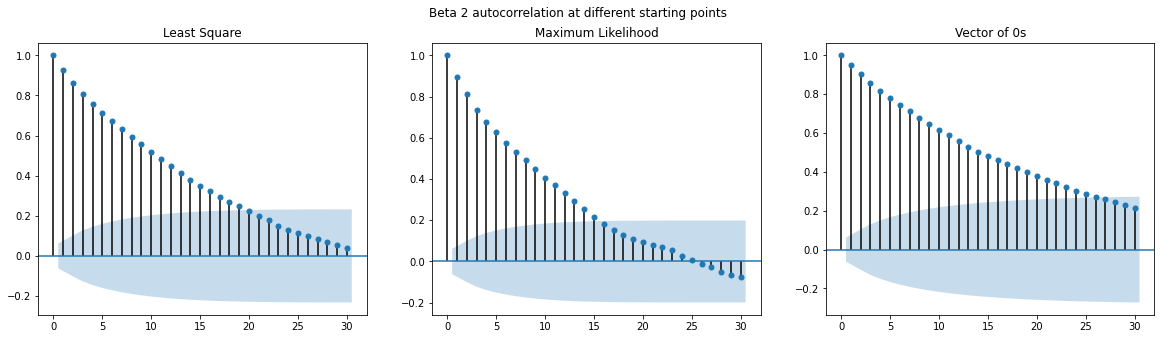

In [ ]:
beta,betapre,betapost,accept, acceptpre, acceptpost=metropolis(X,Y,0.35,1500,1000)
beta_1,betapre_1,betapost_1,accept_1, acceptpre_1, acceptpost_1=metropolis(X,Y,0.35,1500,1000, starting="ML")
beta_2,betapre_2,betapost_2,accept_2, acceptpre_2, acceptpost_2=metropolis(X,Y,0.35,1500,1000, starting="0")

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2,accept, acceptpre, acceptpost,accept_1, acceptpre_1, acceptpost_1, accept_2, acceptpre_2, acceptpost_2)

graphs(betapost,betapost_1,betapost_2, beta=2)

The autocorrelation is particularly persistent as shown by the plots. We, thus, introduce thinning.

Optimization terminated successfully.
         Current function value: 0.472380
         Iterations 6

 Beta estimate having as starting point: 
 Least Square: [-0.52017937  0.2442544   0.63486254 -0.15559099  0.00898609 -0.08027897
  0.41990903  0.1705623   0.1205166 ] 

   Maximum Likelihood: [-0.51104259  0.24314329  0.61941001 -0.15048381  0.01363751 -0.07027535
  0.39889331  0.16864858  0.12546878] 

   Vector of 0s: [-0.50763003  0.24811965  0.62785167 -0.1485101   0.01584244 -0.08116209
  0.4021609   0.15910814  0.11077994] 

Mean of beta estimates:  [-0.51295066  0.24517244  0.62737474 -0.1515283   0.01282201 -0.0772388
  0.40698775  0.16610634  0.11892177]
Overall acceptance rate having as starting point: 

    Least Square: 0.38426666666666665,  Maximum Likelihood: 0.4016, Vector of 0s: 0.3957333333333333 
 
Burn-in acceptance rate having as starting point: 

    Least Square: 0.3942222222222222,  Maximum Likelihood: 0.39955555555555555, Vector of 0s: 0.3928888888888889 

Ite

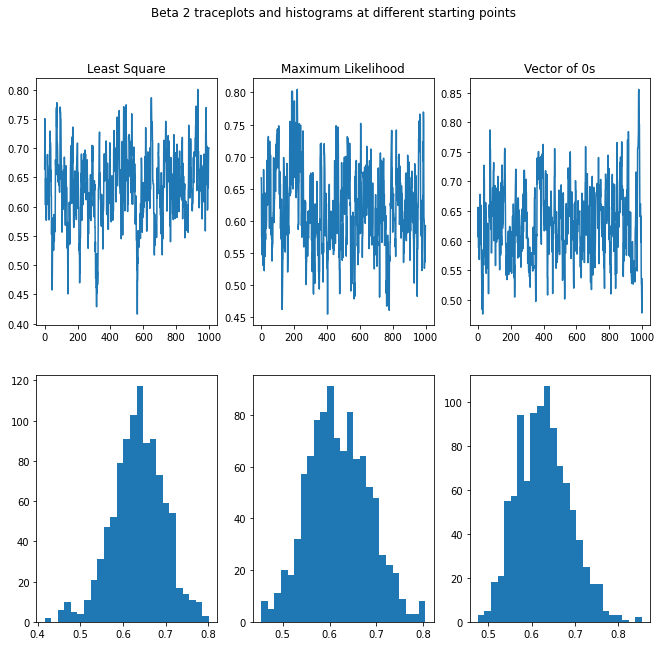

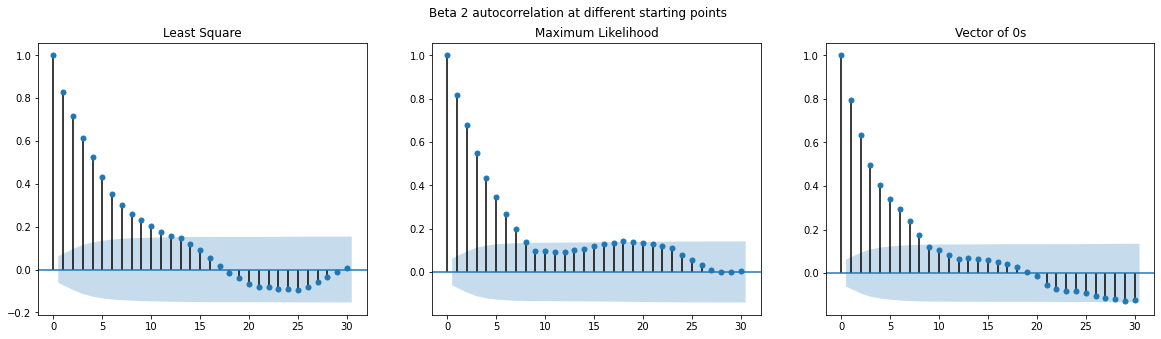

In [ ]:
beta,betapre,betapost,accept, acceptpre, acceptpost=metropolis(X,Y,0.35,4500,3000, thinning=2)
beta_1,betapre_1,betapost_1,accept_1, acceptpre_1, acceptpost_1=metropolis(X,Y,0.35,4500,3000, starting="ML", thinning=2)
beta_2,betapre_2,betapost_2,accept_2, acceptpre_2, acceptpost_2=metropolis(X,Y,0.35,4500,3000, starting="0", thinning=2)

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2,accept, acceptpre, acceptpost,accept_1, acceptpre_1, acceptpost_1, accept_2, acceptpre_2, acceptpost_2)

graphs(betapost,betapost_1,betapost_2, beta=2)

The results are now satisfactory.

### Real data, Auxiliary Gibbs Sampler algorithm with uninformative prior

Optimization terminated successfully.
         Current function value: 0.472380
         Iterations 6

 Beta estimate having as starting point: 
 Least Square: [-0.51453468  0.24392797  0.64066448 -0.15658227  0.02417973 -0.08821367
  0.41483829  0.16431574  0.12114657] 

   Maximum Likelihood: [-0.52234656  0.24091307  0.6418485  -0.15465032  0.02014849 -0.08495301
  0.41843552  0.16508395  0.12230058] 

   Vector of 0s: [-0.51255576  0.23835819  0.63570049 -0.15228115  0.02411518 -0.08783981
  0.41102189  0.17265704  0.12196442] 

Mean of beta estimates:  [-0.516479    0.24106641  0.63940449 -0.15450458  0.02281446 -0.08700216
  0.41476523  0.16735224  0.12180385]
Gelman Rubin statistics:  [1.00802073 1.00122961 1.00173582 1.0003887  1.00027369 0.99988947
 1.00208701 1.00674112 0.99908944]


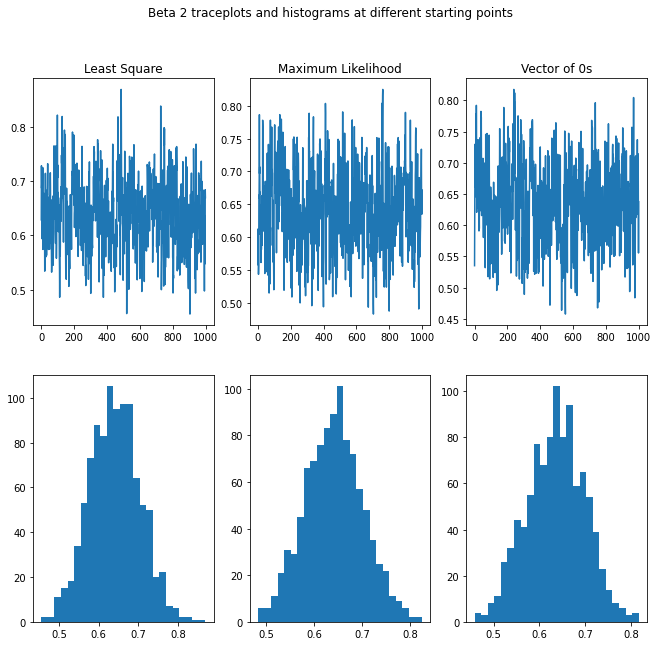

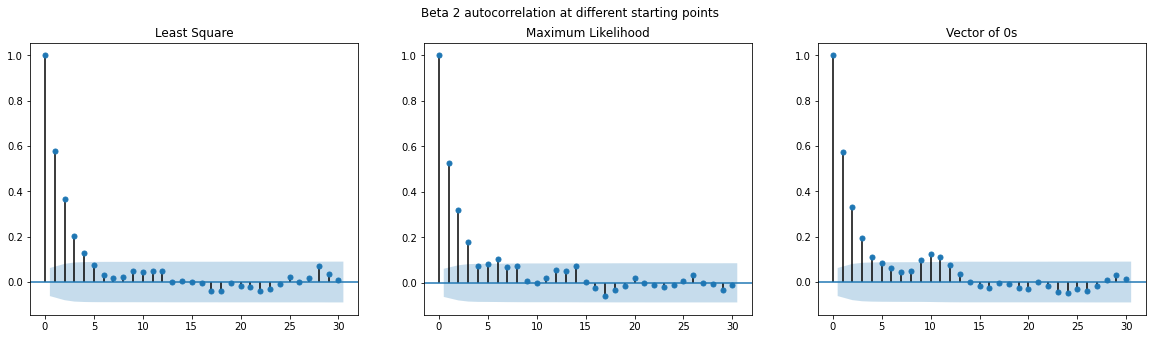

In [ ]:
beta,betapre,betapost=auxiliary_gibbs_sampler(X,Y,1000,1000)
beta_1,betapre_1,betapost_1=auxiliary_gibbs_sampler(X,Y,1000,1000, starting="ML")
beta_2,betapre_2,betapost_2=auxiliary_gibbs_sampler(X,Y,1000,1000, starting="0")

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2)

graphs(betapost,betapost_1,betapost_2, beta=2)

The results, in this case, are staisfactory even without modiflying any of the parameters.

### Real data, Metropolis algorithm with weak normal prior

We start with the set of parameters found in the previous run of the Metropolis Algorithm (as all the same issues as before are still present).

The normal prior we add is particularly weak (unit variance and all values centered at 0). It is the one we would use if we only have a vague idea of what the betas could be.

Optimization terminated successfully.
         Current function value: 0.472380
         Iterations 6

 Beta estimate having as starting point: 
 Least Square: [-0.51273476  0.2516824   0.62805234 -0.15602639  0.02589033 -0.08688904
  0.40736505  0.17332281  0.11332871] 

   Maximum Likelihood: [-0.51449584  0.24642068  0.62956515 -0.14599327  0.0043982  -0.07532281
  0.41792764  0.16183971  0.11965892] 

   Vector of 0s: [-0.52155382  0.24338566  0.6248555  -0.15468949  0.02723306 -0.09027399
  0.40938908  0.16719479  0.12301947] 

Mean of beta estimates:  [-0.51626147  0.24716291  0.627491   -0.15223638  0.01917386 -0.08416195
  0.41156059  0.16745244  0.11866903]
Overall acceptance rate having as starting point: 

    Least Square: 0.3974666666666667,  Maximum Likelihood: 0.3996, Vector of 0s: 0.3872 
 
Burn-in acceptance rate having as starting point: 

    Least Square: 0.402,  Maximum Likelihood: 0.3988888888888889, Vector of 0s: 0.37755555555555553 

Iterations acceptance rate h

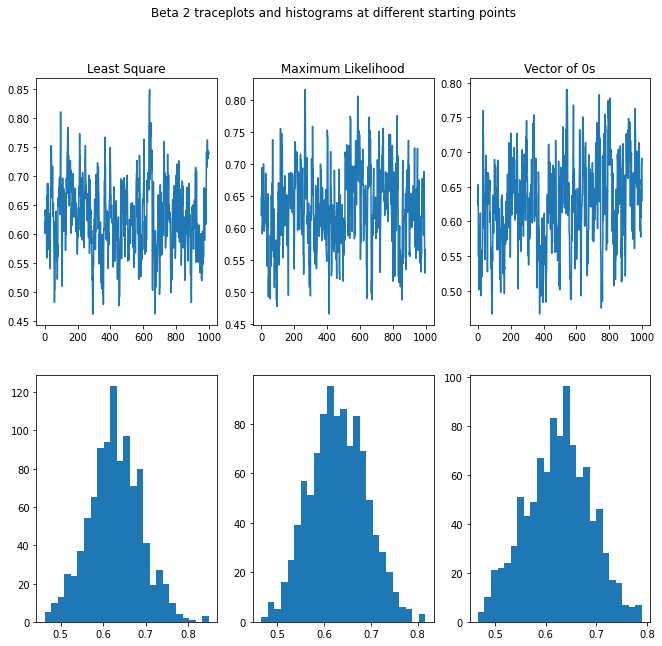

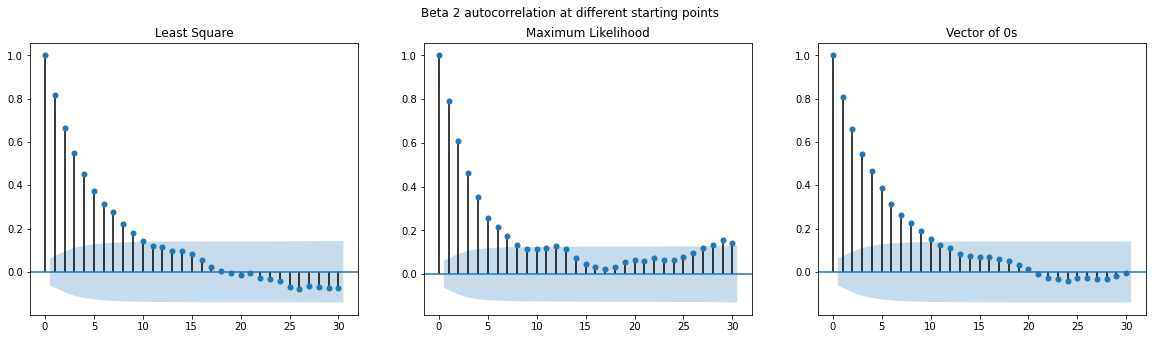

In [ ]:
beta0= [0,0,0,0,0,0,0,0,0]
V0=np.identity(9)

beta,betapre,betapost,accept, acceptpre, acceptpost=metropolis(X,Y,0.35,4500,3000, beta0,V0, thinning=2)
beta_1,betapre_1,betapost_1,accept_1, acceptpre_1, acceptpost_1=metropolis(X,Y,0.35,4500,3000,beta0,V0, starting="ML", thinning=2)
beta_2,betapre_2,betapost_2,accept_2, acceptpre_2, acceptpost_2=metropolis(X,Y,0.35,4500,3000,beta0,V0, starting="0", thinning=2)

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2,accept, acceptpre, acceptpost,accept_1, acceptpre_1, acceptpost_1, accept_2, acceptpre_2, acceptpost_2)

graphs(betapost,betapost_1,betapost_2, beta=2)

The results are satisfactory and we make no further tweaking.

### Real data, Auxiliary Gibbs Sampler algorithm with weak normal prior

Optimization terminated successfully.
         Current function value: 0.472380
         Iterations 6

 Beta estimate having as starting point: 
 Least Square: [-0.51498842  0.24133382  0.63130232 -0.15796046  0.0209309  -0.08797144
  0.41410955  0.15859743  0.1240799 ] 

   Maximum Likelihood: [-0.51281252  0.24668893  0.63459438 -0.15588412  0.01492694 -0.08209128
  0.41010572  0.16359695  0.12023601] 

   Vector of 0s: [-0.51952246  0.24330214  0.63902864 -0.15067929  0.02187719 -0.08727186
  0.41850307  0.16864426  0.12002277] 

Mean of beta estimates:  [-0.51577447  0.24377496  0.63497511 -0.15484129  0.01924501 -0.08577819
  0.41423944  0.16361288  0.12144623]
Gelman Rubin statistics:  [1.00287443 1.00092656 1.00289622 1.00325197 1.0025936  1.00183767
 1.0027766  1.00773102 1.00031002]


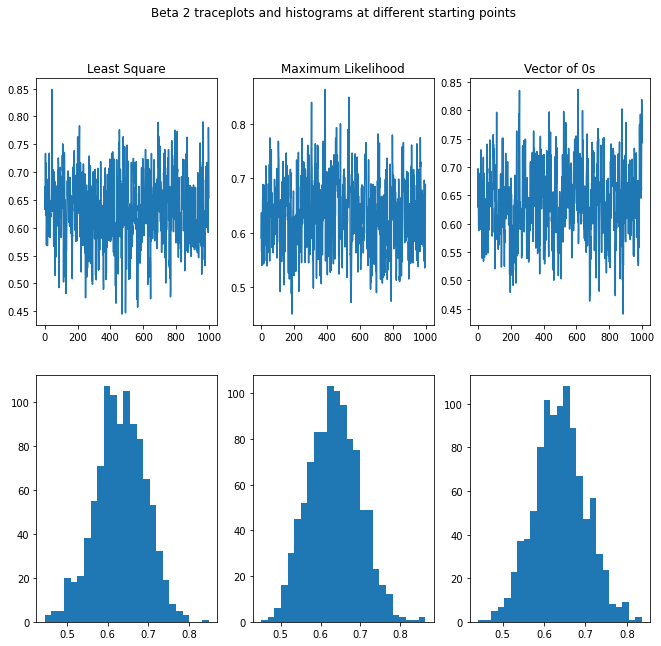

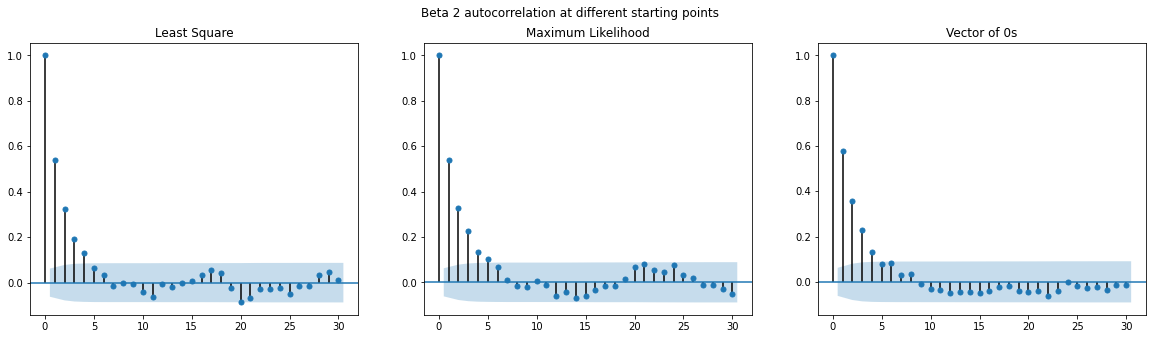

In [ ]:
beta,betapre,betapost=auxiliary_gibbs_sampler(X,Y,1000,1000, beta0,V0)
beta_1,betapre_1,betapost_1=auxiliary_gibbs_sampler(X,Y,1000,1000, beta0,V0,starting="ML")
beta_2,betapre_2,betapost_2=auxiliary_gibbs_sampler(X,Y,1000,1000,beta0,V0,starting="0")

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2)

graphs(betapost,betapost_1,betapost_2, beta=2)

Once again the results are satisfactory with no tweaking of the parameters.

### Real data, Metropolis algorithm with strong normal prior

We now introduce a strong normal prior. The means of it are quite close to the true ones and variance is a lot lower than before. 

Again, we start with the parameters found in the run with the uninformative priors (as all the same issues we noted are still present).


Optimization terminated successfully.
         Current function value: 0.472380
         Iterations 6

 Beta estimate having as starting point: 
 Least Square: [-0.51096973  0.25082107  0.63730278 -0.15418528  0.0256131  -0.08017816
  0.40288432  0.16733033  0.11624496] 

   Maximum Likelihood: [-0.49666883  0.24247232  0.63459914 -0.15384075  0.03574767 -0.09449537
  0.40883448  0.17443774  0.12083828] 

   Vector of 0s: [-0.50217304  0.23944836  0.64021568 -0.15611395  0.03327633 -0.08762081
  0.40743473  0.16970353  0.12564755] 

Mean of beta estimates:  [-0.50327053  0.24424725  0.63737253 -0.15471332  0.0315457  -0.08743145
  0.40638451  0.17049053  0.12091026]
Overall acceptance rate having as starting point: 

    Least Square: 0.3792,  Maximum Likelihood: 0.3904, Vector of 0s: 0.39213333333333333 
 
Burn-in acceptance rate having as starting point: 

    Least Square: 0.3751111111111111,  Maximum Likelihood: 0.3893333333333333, Vector of 0s: 0.3917777777777778 

Iterations acce

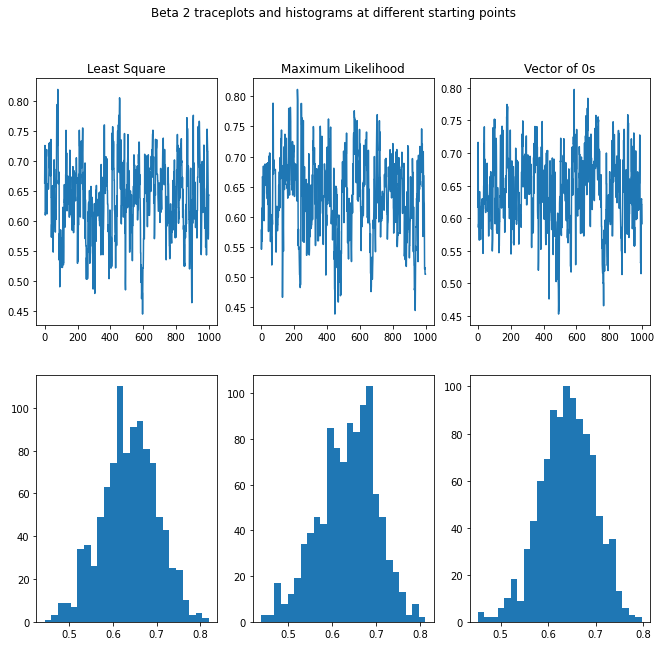

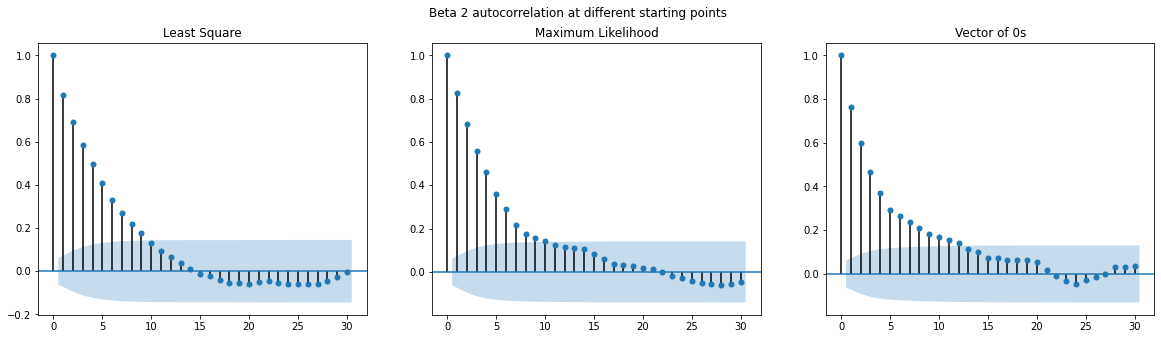

In [ ]:
beta0=[-0.5,0.2,0.6,-0.2,0.1,-0.1,0.5,0.2,0.1]
V0=np.identity(9)*0.1

beta,betapre,betapost,accept, acceptpre, acceptpost=metropolis(X,Y,0.35,4500,3000,beta0,V0, thinning=2)
beta_1,betapre_1,betapost_1,accept_1, acceptpre_1, acceptpost_1=metropolis(X,Y,0.35,4500,3000,beta0,V0, starting="ML", thinning=2)
beta_2,betapre_2,betapost_2,accept_2, acceptpre_2, acceptpost_2=metropolis(X,Y,0.35,4500,3000,beta0,V0, starting="0", thinning=2)

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2,accept, acceptpre, acceptpost,accept_1, acceptpre_1, acceptpost_1, accept_2, acceptpre_2, acceptpost_2)

graphs(betapost,betapost_1,betapost_2, beta=2)

The results are satisfactory and we make no further tweaking.

### Real data, Auxiliary Gibbs Sampler algorithm with strong normal prior

Optimization terminated successfully.
         Current function value: 0.472380
         Iterations 6

 Beta estimate having as starting point: 
 Least Square: [-0.51156503  0.24288365  0.63456516 -0.15039318  0.02840234 -0.09217104
  0.42007008  0.15954757  0.12052883] 

   Maximum Likelihood: [-0.51950107  0.24680854  0.64422026 -0.16214228  0.02575176 -0.09188517
  0.41484434  0.16809886  0.11946206] 

   Vector of 0s: [-0.51771338  0.2431041   0.63695351 -0.15418724  0.02046081 -0.08338243
  0.41590821  0.16927547  0.11611628] 

Mean of beta estimates:  [-0.51625983  0.24426543  0.63857965 -0.15557423  0.02487164 -0.08914621
  0.41694088  0.16564063  0.11870239]
Gelman Rubin statistics:  [1.00489178 1.00034036 1.00525279 1.00950158 1.00324442 1.00601827
 1.00091342 1.00886213 1.00033873]


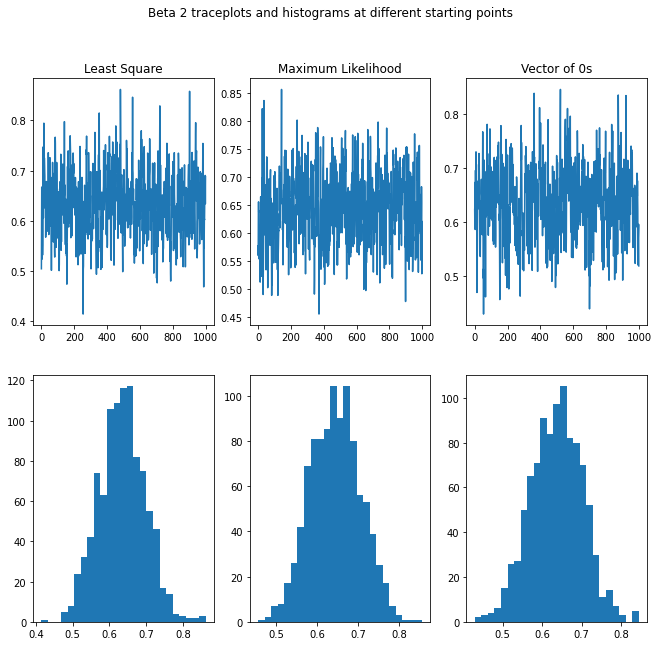

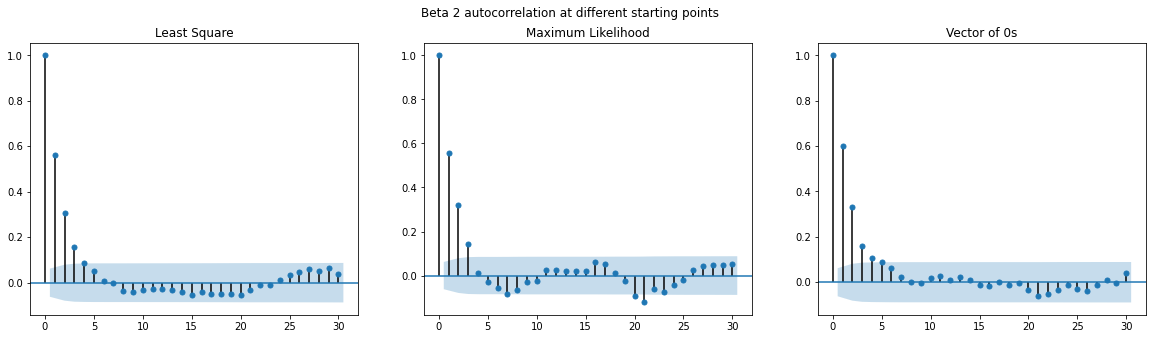

In [ ]:
beta,betapre,betapost=auxiliary_gibbs_sampler(X,Y,1000,1000, beta0,V0)
beta_1,betapre_1,betapost_1=auxiliary_gibbs_sampler(X,Y,1000,1000, beta0,V0,starting="ML")
beta_2,betapre_2,betapost_2=auxiliary_gibbs_sampler(X,Y,1000,1000,beta0,V0,starting="0")

stats(beta,betapost,beta_1,betapost_1,beta_2,betapost_2)

graphs(betapost,betapost_1,betapost_2, beta=2)

Again, the results are satisfactory with the default parameters and there's no need to modify them.